In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from anndata import AnnData
from scipy.sparse import csr_matrix

import FACSPy as fp

import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
input_directory = "C:/Users/tarik/RGBLab/Franca/NK_spectral_full/paper/schayan_data/"

In [4]:
full_expression = pd.read_csv(os.path.join(input_directory, "expr_data_full.csv"), index_col = [0])

C:\Users\tarik\AppData\Local\Temp\ipykernel_27412\2252137775.py:1: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  full_expression = pd.read_csv(os.path.join(input_directory, "expr_data_full.csv"), index_col = [0])


In [5]:
all_cells = pd.read_csv(os.path.join(input_directory, "metadata_wo_BAL.csv"), index_col = [0])
all_cells = all_cells.set_index("Cells")
all_cells["clusters_predicted"] = all_cells["clusters_predicted"].astype("string")

C:\Users\tarik\AppData\Local\Temp\ipykernel_27412\4061554832.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  all_cells = pd.read_csv(os.path.join(input_directory, "metadata_wo_BAL.csv"), index_col = [0])


In [6]:
full_expression = full_expression[full_expression["Cells"].isin(all_cells.index.tolist())]

In [7]:
non_expression_columns = ["Time", "sample", "donor", "group", "condition", "batch", "cells_per_sample", "sample_removed", "Cells"]
expression_columns = [col for col in full_expression.columns if col not in non_expression_columns]

In [8]:
adata = AnnData(
    X = full_expression[expression_columns].to_numpy(dtype = np.float64),
    obs = full_expression[non_expression_columns].set_index("Cells"),
    var = pd.DataFrame(data = {"type": "fluo"}, index = pd.Index(expression_columns)),
    obsm = {"gating": csr_matrix(np.ones(shape = (full_expression.shape[0], 1)))},
    uns = {"gating_cols": pd.Index(["all_cells"])}
)

adata.layers["compensated"] = adata.X.copy()
adata.obs = adata.obs.merge(all_cells[["ratio", "ratio_anno", "leverage.score", "clusters_predicted"]], left_index = True, right_index = True)

In [9]:
#fp.dt.transform(adata, transform = "logicle", key_added = "transformed", layer = "compensated")
adata.layers["transformed"] = adata.layers["compensated"].copy()

In [10]:
doublet_data = pd.read_csv(os.path.join(input_directory, "sketch_df_v2.csv"))
doublet_data.head()

C:\Users\tarik\AppData\Local\Temp\ipykernel_27412\627737971.py:1: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  doublet_data = pd.read_csv(os.path.join(input_directory, "sketch_df_v2.csv"))


,Unnamed: 0,FSC-A,FSC-H,CD66b,CD8,PD-1,CD18,CD14,CD38,NKG2C,...,ratio_anno,leverage.score,sketch_snn_res.1,sketch_snn_res.2,sketch_snn_res.3,sketch_snn_res.4,seurat_clusters,clusters_predicted,umap_1,umap_2
0,Cell_10,374,289,456,366,281,870,797,647,376,...,Ratio_low,0.000627,1,1,24,4,4,4,-2.637577,-8.951240
1,Cell_44,367,304,322,471,605,800,233,341,811,...,Ratio_low,0.002018,26,29,33,33,33,33,8.728064,-1.626608
2,Cell_118,407,304,334,922,378,805,269,416,431,...,Ratio_low,0.000610,15,33,35,34,34,18,8.056905,4.556773
3,Cell_120,492,380,451,407,357,870,482,436,370,...,Ratio_low,0.000736,18,16,15,45,45,45,-2.267729,-5.048316
4,Cell_129,320,281,368,383,357,617,238,601,485,...,Ratio_low,0.000294,7,3,2,1,1,1,-2.390359,10.367218


In [11]:
expr_data_doublets = pd.read_csv(os.path.join(input_directory, "expr_data_doublets.csv"))
expr_data_doublets.head()
fluo_channels = [ch for ch in expr_data_doublets.columns if not "Unnamed" in ch]
print(fluo_channels)

['CD66b', 'CD8', 'PD-1', 'CD18', 'CD14', 'CD38', 'NKG2C', 'CD3', 'CD16', 'CD161', 'CD32', 'CD56', '41BB', 'CD64', 'KLRG1', 'HLA-DR', 'CD19', 'NKp44', 'CD69', 'TIGIT', 'CD57', 'NKG2A', 'TRAIL', 'CTLA-4', 'CD27', 'CD4']


In [12]:
dadata = AnnData(X = doublet_data[fluo_channels].to_numpy(),
                 obs = doublet_data[[col for col in doublet_data.columns if col not in fluo_channels]].set_index("Unnamed: 0"),
                 var = pd.DataFrame(data = {"type": "fluo"}, index = pd.Index(fluo_channels)),
                 obsm = {"X_umap_all_cells_transformed": doublet_data[["umap_1", "umap_2"]].to_numpy(),
                         "gating": csr_matrix(np.ones(shape = (doublet_data.shape[0], 1)))},
                 layers = {"transformed": doublet_data[fluo_channels].to_numpy()},
                 uns = {"gating_cols": pd.Index(["all_cells"])})
dadata.obs["sample_ID"] = dadata.obs["sample"]
dadata.obs["clusters_predicted"] = dadata.obs["clusters_predicted"].astype("string")

In [13]:
lineage_markers = ["CD3", "CD56", "CD14", "CD16", "CD19", "CD4", "CD8", "CD66b"]

In [14]:
fp.tl.mfi(dadata, groupby = "clusters_predicted", layer = "transformed", aggregate = True)

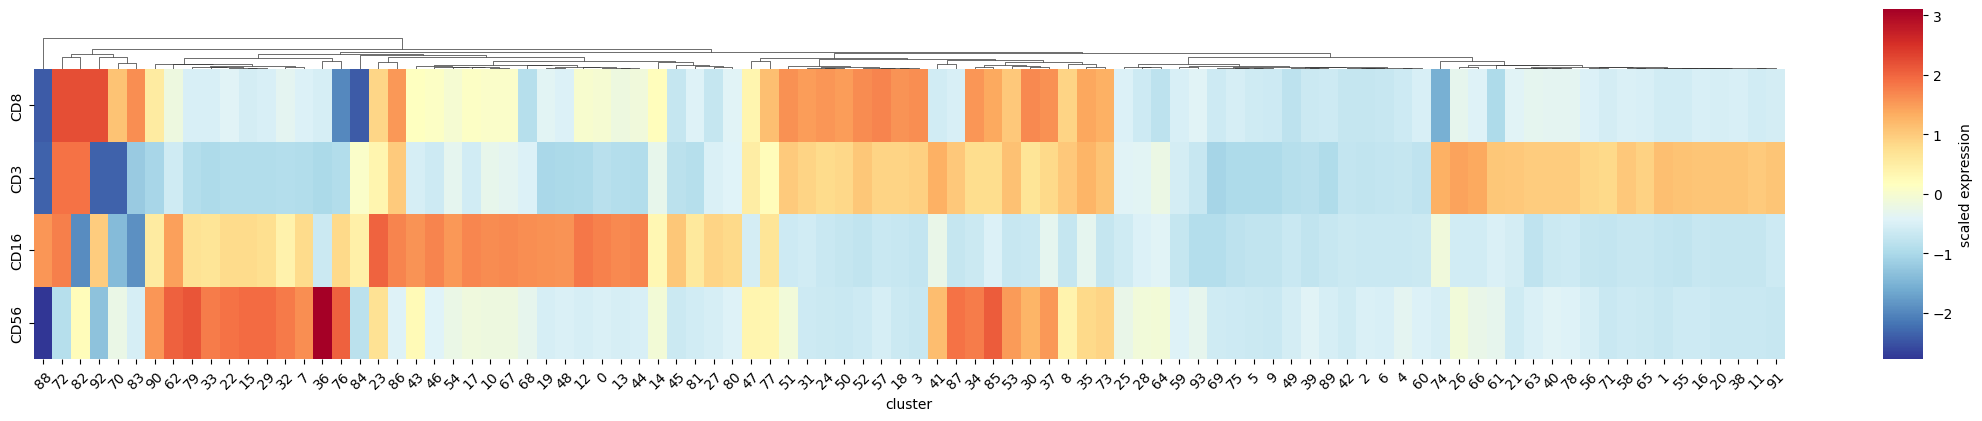

In [15]:
sns.reset_defaults()
fp.pl.cluster_heatmap(dadata,
                      layer = "transformed",
                      gate = "all_cells",
                      scaling = "StandardScaler",
                      cluster_key = "clusters_predicted",
                      figsize = (20,4),
                      exclude = [ch for ch in dadata.var.index if ch not in lineage_markers or ch not in ["CD3", "CD16", "CD56", "CD8"]])

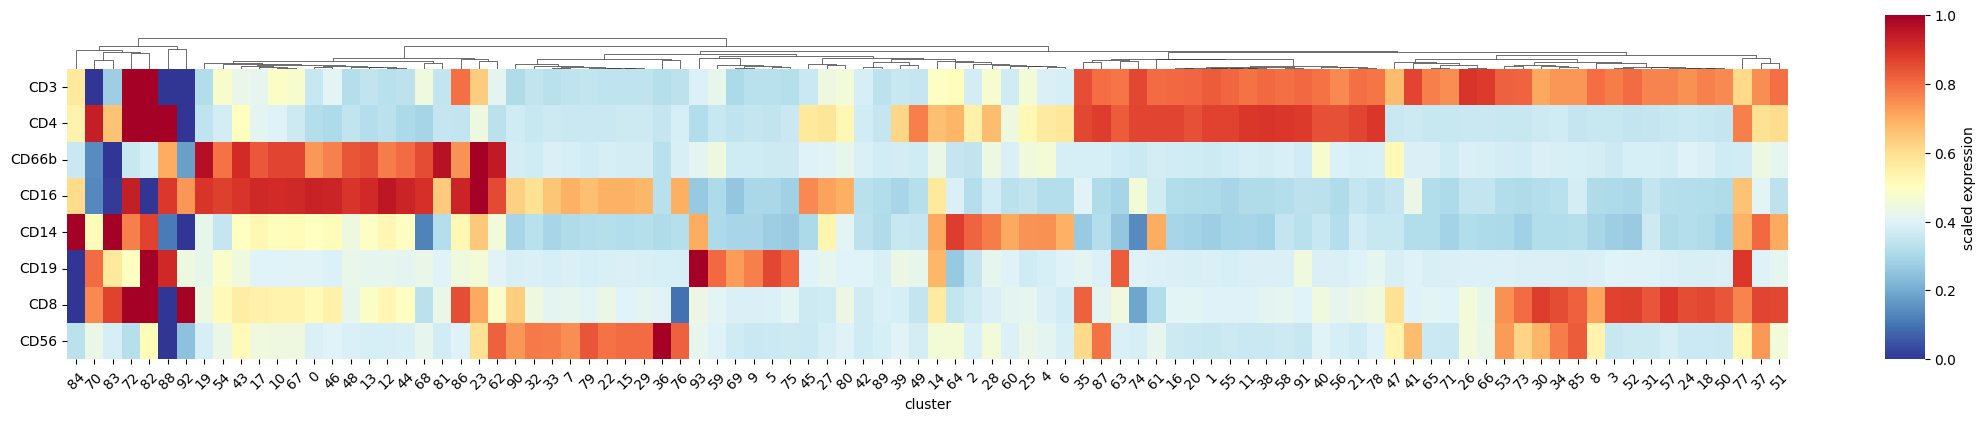

In [16]:
fp.pl.cluster_heatmap(dadata,
                      layer = "transformed",
                      gate = "all_cells",
                      scaling = "MinMaxScaler",
                      cluster_key = "clusters_predicted",
                      figsize = (20,4),
                      exclude = [ch for ch in dadata.var.index if ch not in lineage_markers])

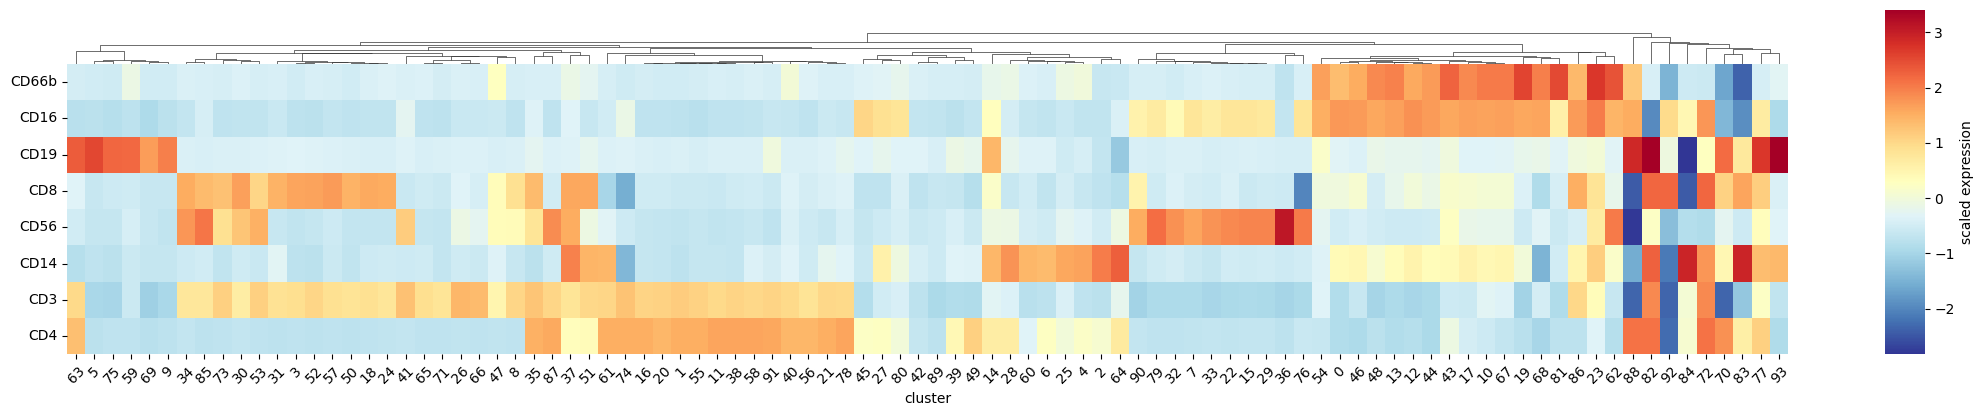

In [17]:
fp.pl.cluster_heatmap(dadata,
                      layer = "transformed",
                      gate = "all_cells",
                      scaling = "StandardScaler",
                      cluster_key = "clusters_predicted",
                      figsize = (20,4),
                      exclude = [ch for ch in dadata.var.index if ch not in lineage_markers])

In [18]:
cluster_mapping = {
    "63": "T_B", #CD3 + CD19
    "5": "B", "75": "B", "59": "B", "9": "B", "69": "B", # CD19 only
    "34": "CD8T", "85": "CD8T", "73": "CD8T", "30": "CD8T", "53": "CD8T", # CD8+CD3+CD56
    "31": "CD8T", "3": "CD8T", "52": "CD8T", "57": "CD8T", "50": "CD8T", "18": "CD8T", "24": "CD8T", # CD8+CD3
    "41": "DNT", "65": "DNT", "71": "DNT", "26": "DNT", "66": "DNT", # CD3 (+ CD56)
    "8": "CD8T", "47": "CD8T_NEU", "35": "DPT_NK", "87": "CD4T",
    "37": "T_MONO", "51": "T_MONO", "61": "T_MONO",
    "74": "CD4T", "16": "CD4T", "20": "CD4T", "1": "CD4T" ,"55": "CD4T", "11": "CD4T", "38": "CD4T","58": "CD4T","91": "CD4T", "40": "CD4T", "56": "CD4T", "21": "CD4T", "78": "CD4T",
    #"45": "CD4+CD16+", "27": "CD4+CD16+CD14+",
    "45": "MONO", "27": "MONO",
    "80": "CD16+",
    "42": "NAC", "89": "NAC",
    "39": "unconv_T_cells", "49": "unconv_T_cells",
    "14": "B_MONO",
    "28": "MONO", "60": "MONO", "6": "MONO", "4": "MONO", "25": "MONO", "2": "MONO", "64": "MONO",
    "90": "NK", "79": "NK", "32": "NK", "7": "NK", "33": "NK", "22": "NK", "15": "NK", "29": "NK", "36": "NK", "76": "NK",
    "54": "NEUS", "0": "NEUS", "46": "NEUS", "48": "NEUS", "13": "NEUS", "12": "NEUS", "44": "NEUS", "43": "NEUS", "17": "NEUS", "10": "NEUS", "67": "NEUS", "19": "NEUS", "68": "NEUS", "81": "NEUS",
    "86": "T_NEU", "23": "T_NEU",
    "62": "T_MONO",
    "88": "B_NEU_T",
    "82": "T_MONO_B",
    "92": "CD8T", "84": "T_MONO",
    "72": "T_MONO", "70": "T_MONO_B", "83": "T_MONO_B", "77": "T_MONO_B",
    "93": "B_MONO"
}


In [19]:
dadata.obs["annotation"] = dadata.obs["clusters_predicted"].map(cluster_mapping)

interacting_clusters = ["63", "47", "37", "51", "61", "14", "86", "23", "62", "88", "82", "92", "84", "72", "70", "83", "77", "93"]
all_clusters = [str(i) for i in range(94)]
interacting_map = {
    cluster: "interacting" if cluster in interacting_clusters else "non_interacting"
    for cluster in all_clusters
}
dadata.obs["interaction"] = dadata.obs["clusters_predicted"].map(interacting_map)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


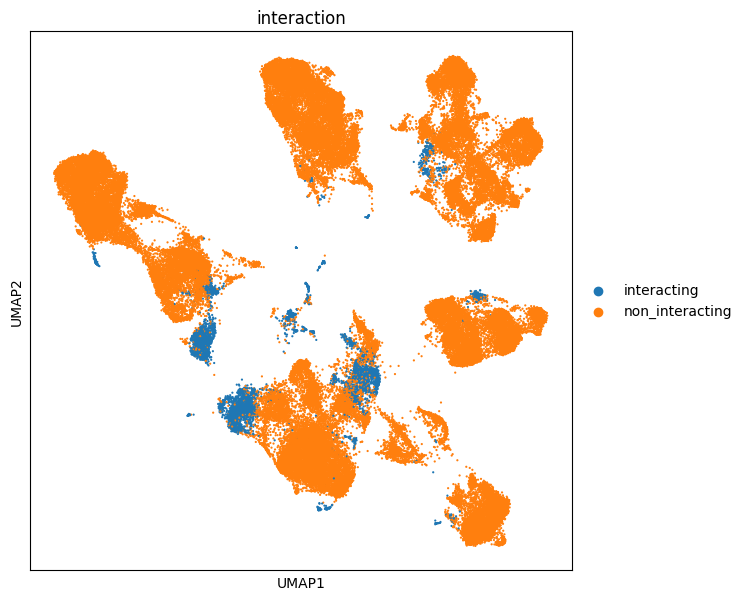

In [20]:
fp.pl.umap(dadata, gate = "all_cells", layer = "transformed", color = "interaction", figsize = (7,7), s = 10)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


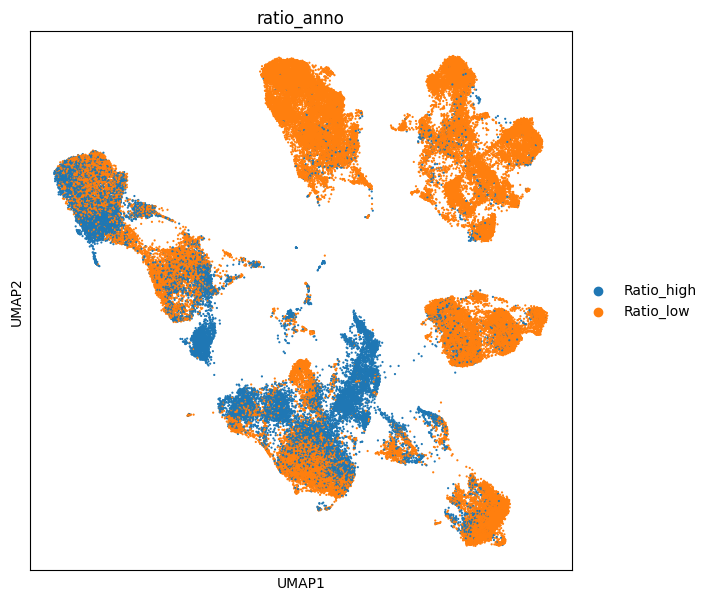

In [21]:
fp.pl.umap(dadata, gate = "all_cells", layer = "transformed", color = "ratio_anno", figsize = (7,7), s = 10)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


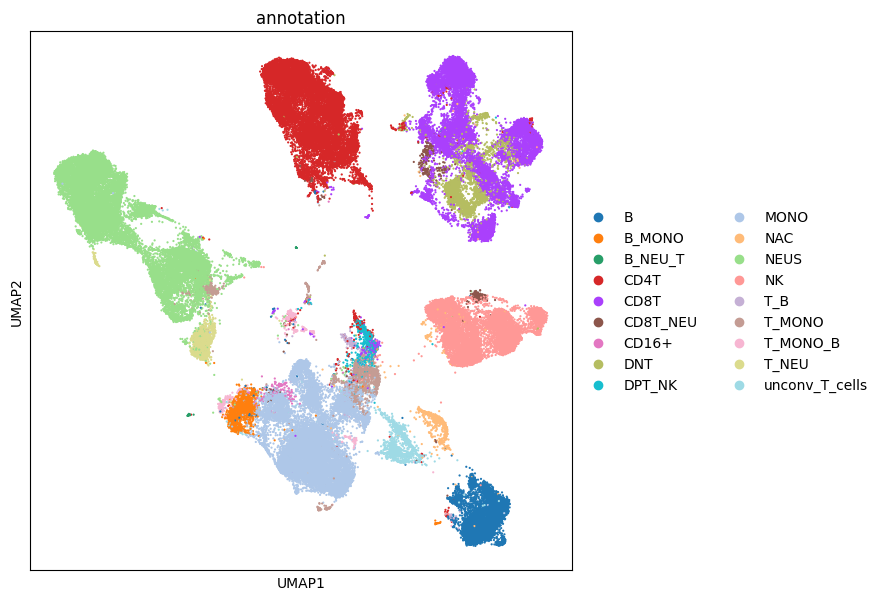

In [22]:
fp.pl.umap(dadata, gate = "all_cells", layer = "transformed", color = "annotation", figsize = (7,7), s = 10)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


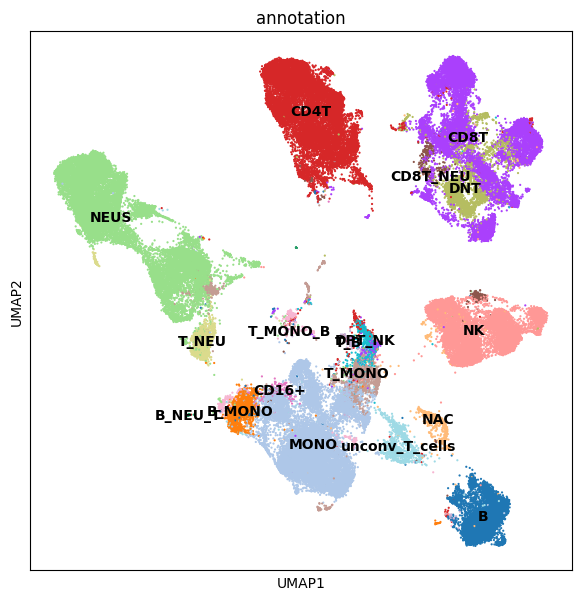

In [23]:
fp.pl.umap(dadata, gate = "all_cells", layer = "transformed", color = "annotation", figsize = (7,7), s = 10, legend_loc = "on data")

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


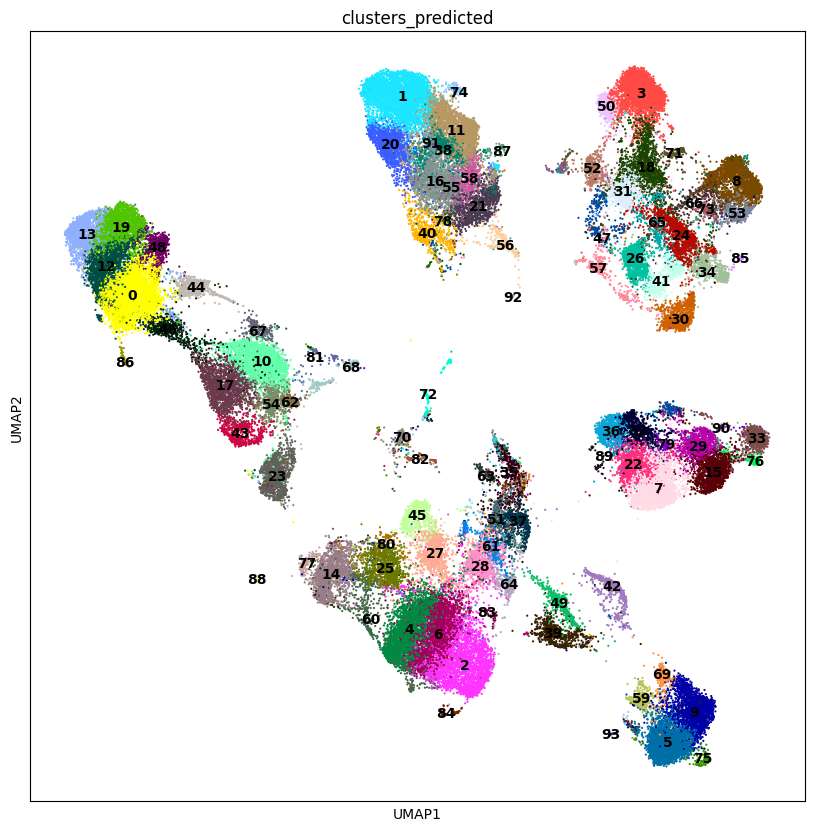

In [24]:
fp.pl.umap(dadata, gate = "all_cells", layer = "transformed", color = "clusters_predicted", figsize = (10,10), s = 10, legend_loc = "on data")

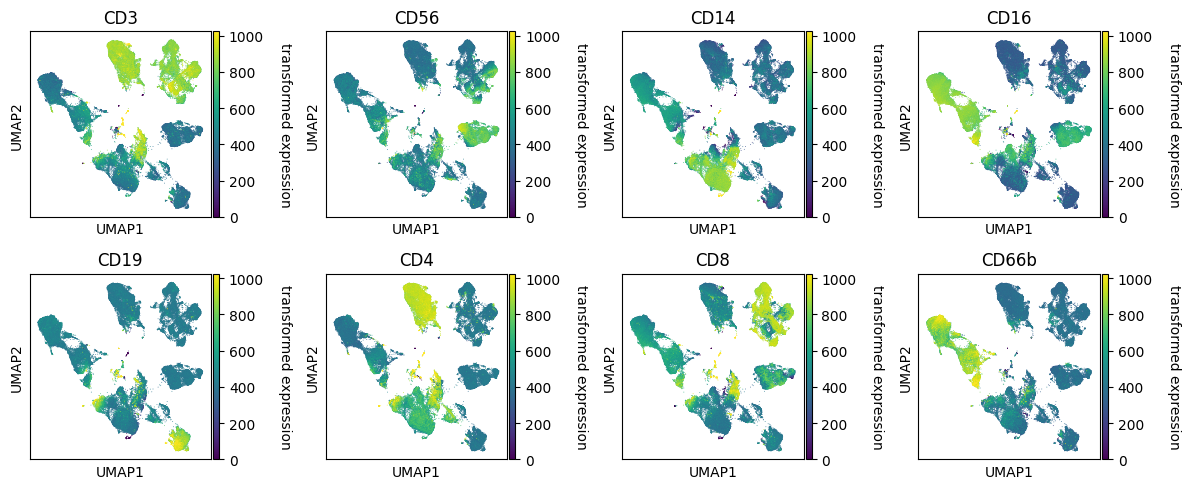

In [25]:
fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (12,5))
ax = ax.flatten()
for i, marker in enumerate(lineage_markers):
    fp.pl.umap(dadata, layer = "transformed", gate = "all_cells", color = marker, ax = ax[i], show = False)
    ax[i].set_title(marker)
plt.tight_layout()
plt.show()
    

In [26]:
adata.obs["annotation"] = adata.obs["clusters_predicted"].map(cluster_mapping)

interacting_map = {
    cluster: "interacting" if cluster in interacting_clusters else "non_interacting"
    for cluster in all_clusters
}
adata.obs["interaction"] = adata.obs["clusters_predicted"].map(interacting_map)

In [27]:
interacting = adata[adata.obs["interaction"] == "interacting"].copy()
fp.tl.pca(interacting, gate = "all_cells", layer = "transformed")
fp.tl.neighbors(interacting, gate = "all_cells", layer = "transformed")
fp.tl.umap(interacting, gate = "all_cells", layer = "transformed")

In [28]:
fp.tl.leiden(interacting, gate = "all_cells", layer = "transformed", resolution = 4)
print(f"Unique clusters: {interacting.obs['all_cells_transformed_leiden'].unique().shape[0]}")

Unique clusters: 74


In [29]:
fp.tl.mfi(interacting, groupby = "all_cells_transformed_leiden", layer = "transformed", aggregate = True)

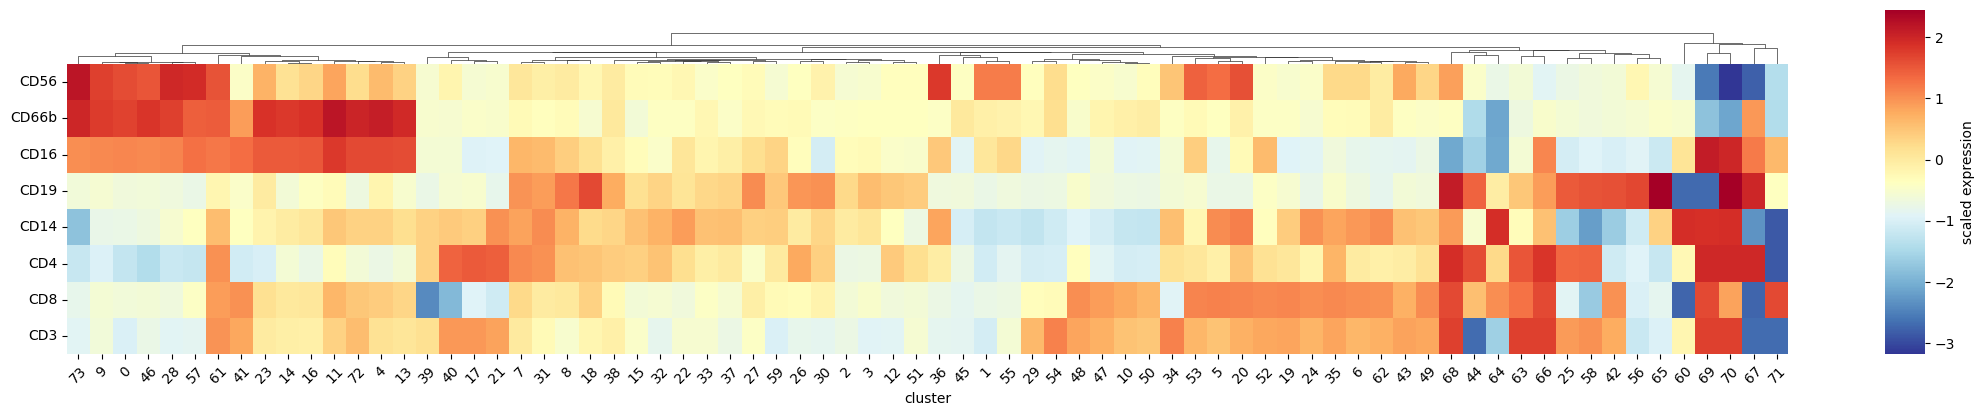

In [30]:
fp.pl.cluster_heatmap(interacting,
                      layer = "transformed",
                      gate = "all_cells",
                      scaling = "StandardScaler",
                      cluster_key = "all_cells_transformed_leiden",
                      figsize = (20,4),
                      exclude = [ch for ch in interacting.var.index if ch not in lineage_markers])

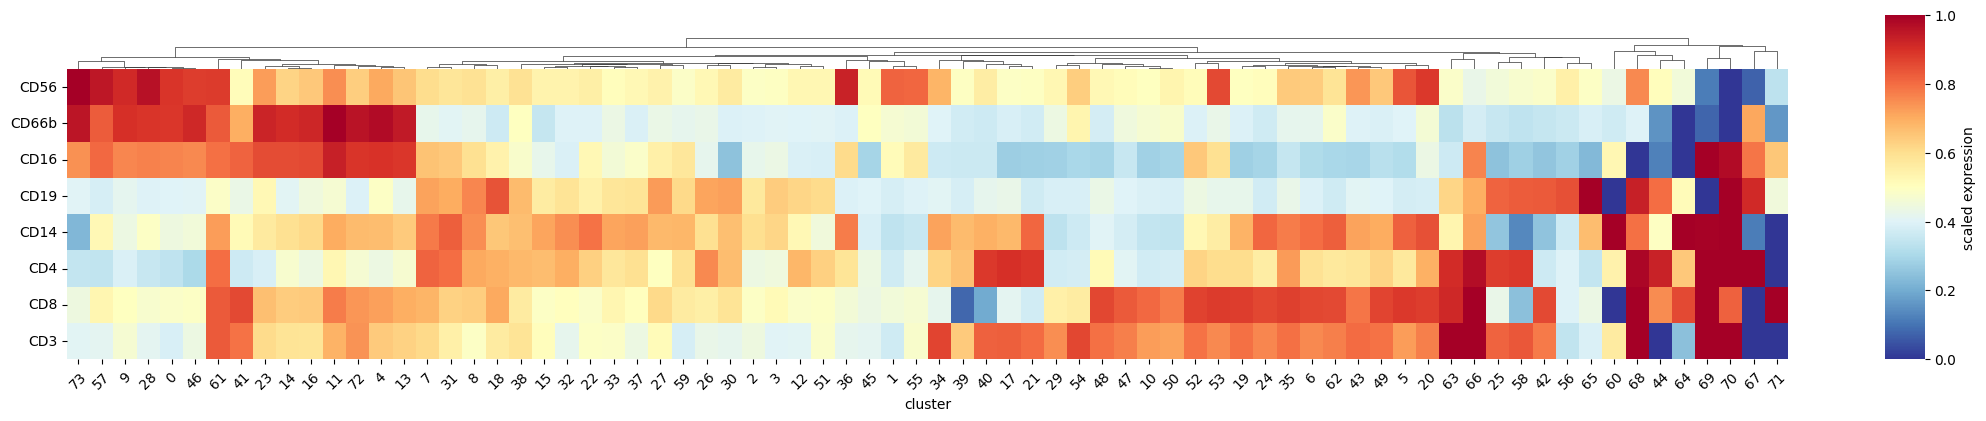

In [31]:
sns.reset_defaults()
fp.pl.cluster_heatmap(interacting,
                      layer = "transformed",
                      gate = "all_cells",
                      scaling = "MinMaxScaler",
                      cluster_key = "all_cells_transformed_leiden",
                      figsize = (20,4),
                      exclude = [ch for ch in interacting.var.index if ch not in lineage_markers])

In [32]:
cluster_mapping_new = {
    "73": "NK_NEU", "9": "NK_NEU", "0": "NK_NEU", "46": "NK_NEU", "28": "NK_NEU", "57": "NK_NEU", "61": "NK_T_MONO_NEU",
    "41": "T_NEU", "23": "T_NEU", "14": "T_NEU", "16": "T_NEU", "11": "T_NEU", "72": "T_NEU", "4": "T_NEU", "13": "T_NEU",
    "39": "T_MONO", "40": "T_MONO", "17": "T_MONO", "21": "T_MONO",
    "7": "MONO_B", "31": "MONO_B", "8": "MONO_B", "18": "MONO_B", "38": "MONO_B", "15": "MONO_B", "32": "MONO_B", "22": "MONO_B", "33": "MONO_B",
    "37": "MONO_B", "27": "MONO_B", "59": "MONO_B", "26": "MONO_B", "30": "MONO_B", "2": "MONO_B", "3": "MONO_B", "12": "MONO_B", "51": "MONO_B",
    "36": "NK_MONO", "45": "NAC",
    "1": "NK", "55": "NK", "29": "CD8T", "54": "CD8T", "48": "CD8T", "47": "CD8T", "10": "CD8T", "50": "CD8T",
    "34": "T_MONO", "53": "NK_T", "5": "T_MONO", "20": "NK_T", "52": "T_MONO", "19": "T_MONO", "24": "T_MONO", "35": "T_MONO", "6": "T_MONO", "62": "T_MONO", "43": "T_MONO", "49": "T_MONO",
    "68": "T_B", "44": "T_B", "64": "T_B", "63": "T_B", "66": "T_B", "25": "T_B", "58": "T_B", "42": "T_B",
    "56": "B", "65": "B", "60": "MONO", "69": "T_MONO", "70": "T_MONO_B", "67": "MONO_NEU", "71": "T_MONO" 
}

In [33]:
non_interacting_clusters = ["45", "1", "55", "29", "54", "48", "47", "10", "50", "56", "65", "60"]
interacting_map = {
    cluster: "interacting"
    if cluster not in non_interacting_clusters else "non_interacting"
    for cluster in interacting.obs["all_cells_transformed_leiden"].unique()
}

In [34]:
group_map = {
    "HC": "healthy: PB",
    "SF": "infl. arthritis: SF",
    "blood SF": "infl. arthritis: PB"
}
interacting.obs["group"] = interacting.obs["group"].map(group_map)
interacting.obs["annotation"] = [annot.replace("_", "::") for annot in interacting.obs["annotation"]]

In [35]:
interacting.obs["new_annotation"] = interacting.obs["all_cells_transformed_leiden"].map(cluster_mapping_new)
interacting.obs["interaction"] = interacting.obs["all_cells_transformed_leiden"].map(interacting_map)

In [36]:
interacting.obs["final_annotation"] = [
    "singlet" if interaction == "non_interacting" else doublet.replace("_", "::")
    for interaction, doublet in zip(interacting.obs["interaction"].tolist(), interacting.obs["new_annotation"].tolist())
]

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


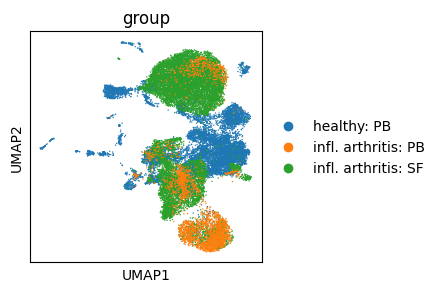

In [37]:
fp.pl.umap(interacting, gate = "all_cells", layer = "transformed", color = "group")

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


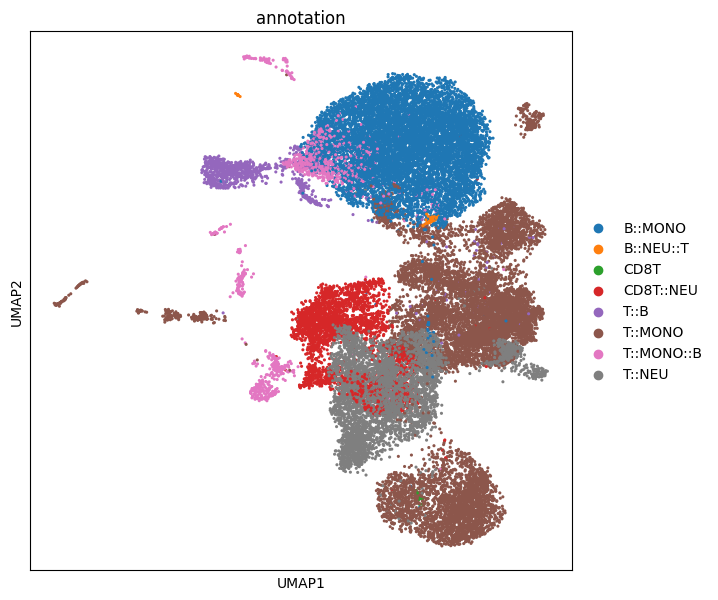

In [38]:
fp.pl.umap(interacting, gate = "all_cells", layer = "transformed", color = "annotation", figsize = (7,7), s = 20)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


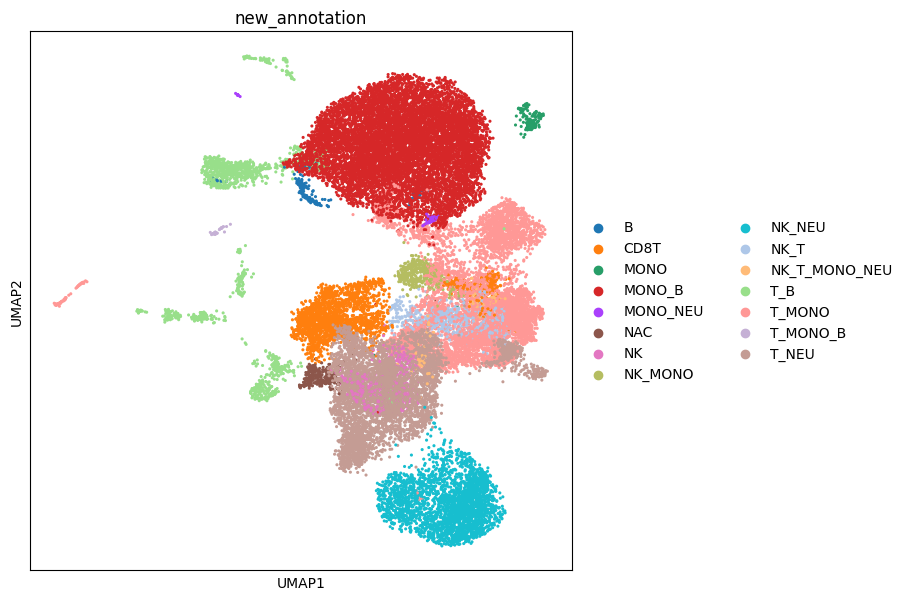

In [39]:
fp.pl.umap(interacting, gate = "all_cells", layer = "transformed", color = "new_annotation", figsize = (7,7), s = 20)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


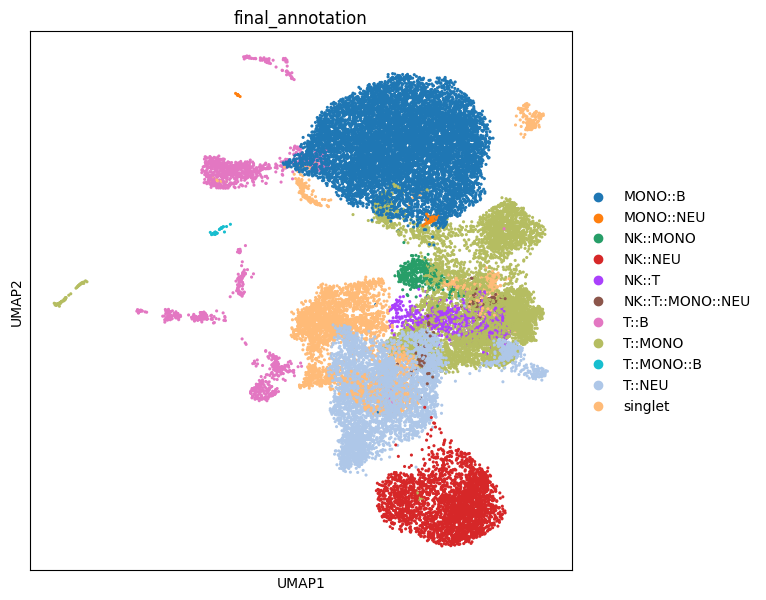

In [40]:
fp.pl.umap(interacting, gate = "all_cells", layer = "transformed", color = "final_annotation", figsize = (7,7), s = 20)

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


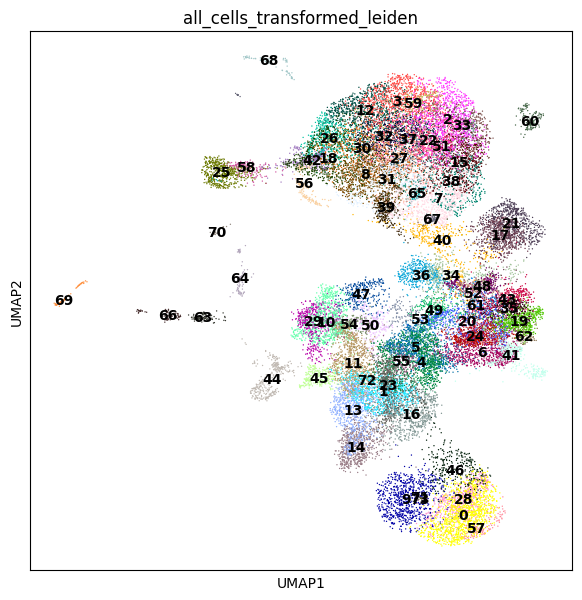

In [41]:
fp.pl.umap(interacting, gate = "all_cells", layer = "transformed", color = "all_cells_transformed_leiden", figsize = (7,7), legend_loc = "on data")

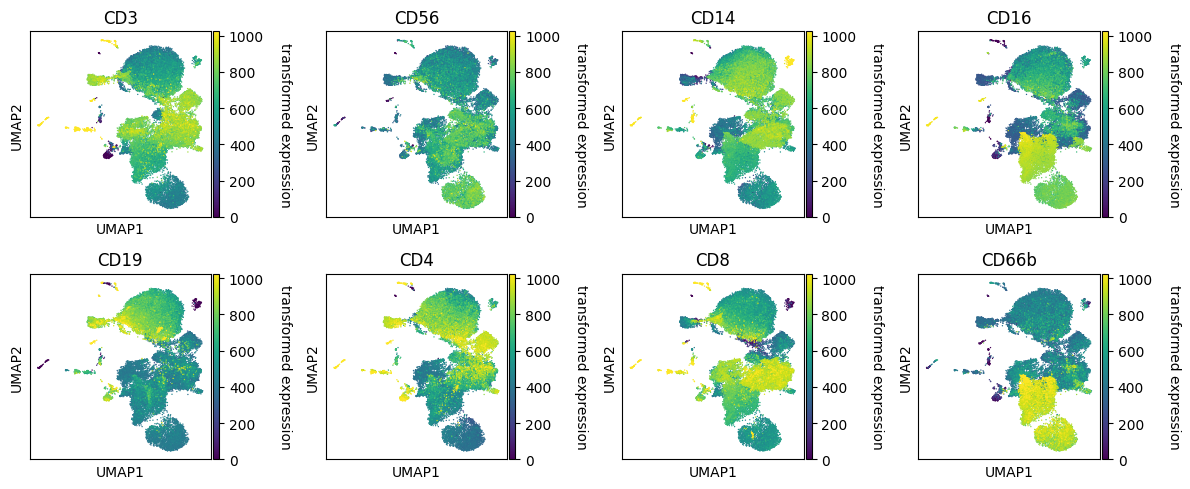

In [42]:
fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (12,5))
ax = ax.flatten()
for i, marker in enumerate(lineage_markers):
    fp.pl.umap(interacting, layer = "transformed", gate = "all_cells", color = marker, ax = ax[i], show = False)
    ax[i].set_title(marker)
plt.tight_layout()
plt.show()
    

In [43]:
# Make a copy and convert the relevant columns to string
df = interacting.obs.copy()
df = df[df["final_annotation"] != "singlet"]
df[["group", "donor", "final_annotation"]] = df[["group", "donor", "final_annotation"]].astype(str)

# Count combinations of group, donor, and new_annotation (only observed ones)
grouped_counts = df.groupby(["group", "donor", "final_annotation"], observed=True).size()

# Calculate total counts per (group, donor)
total_counts = df.groupby(["group"]).size()

doublet_perc = grouped_counts / total_counts
doublet_perc = doublet_perc.reset_index(name = "perc")

doublet_perc

,group,donor,final_annotation,perc
0,healthy: PB,Donor1,MONO::B,0.001237
1,healthy: PB,Donor1,NK::MONO,0.011031
2,healthy: PB,Donor1,NK::NEU,0.001546
3,healthy: PB,Donor1,NK::T,0.019588
4,healthy: PB,Donor1,NK::T::MONO::NEU,0.002680
...,...,...,...,...
137,infl. arthritis: SF,Donor26,NK::NEU,0.003873
138,infl. arthritis: SF,Donor26,NK::T::MONO::NEU,0.000070
139,infl. arthritis: SF,Donor26,T::B,0.000282
140,infl. arthritis: SF,Donor26,T::MONO,0.000352


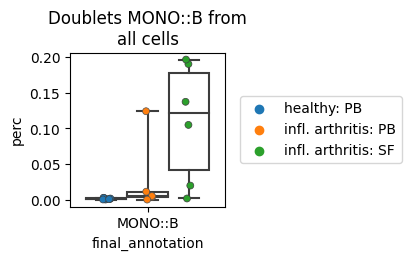

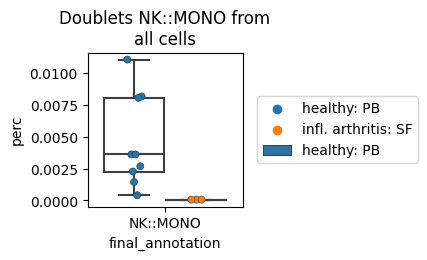

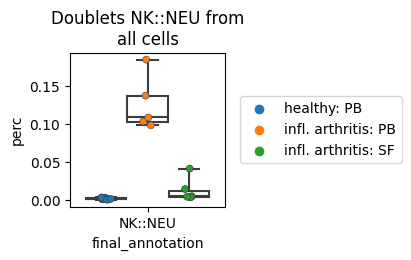

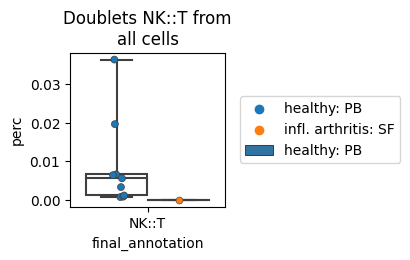

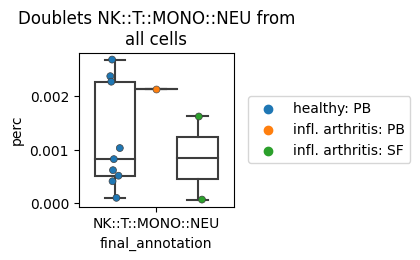

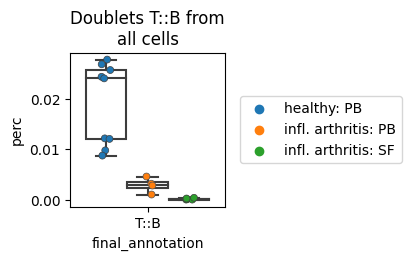

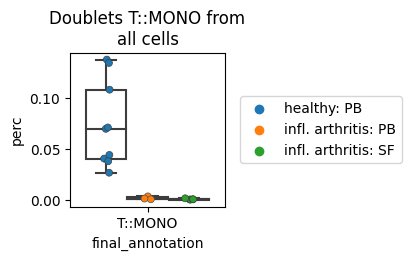

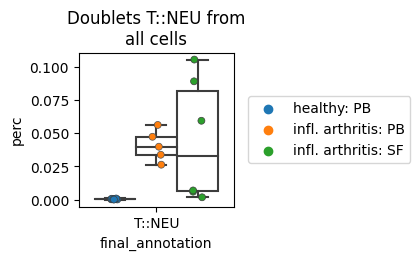

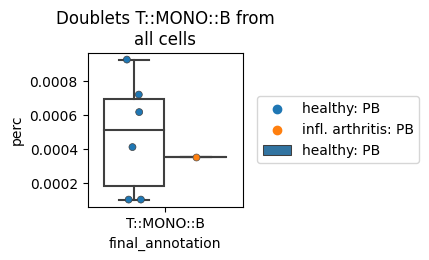

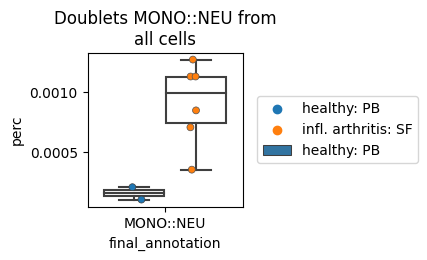

In [44]:
for annotation in doublet_perc["final_annotation"].unique():
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (2,2))
    plot_params = {
        "data": doublet_perc[
            (doublet_perc["final_annotation"] == annotation) & True
        ],
        "x": "final_annotation",
        "y": "perc",
        "hue": "group",
        "dodge": True
    }
    sns.stripplot(**plot_params, linewidth = 0.5)
    sns.boxplot(**plot_params, boxprops = dict(facecolor = "white"), whis = (0,100))
    
    ax.set_title(f"Doublets {annotation} from\nall cells")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:3], labels[:3], bbox_to_anchor = (1.05, 0.5), loc = "center left")
    plt.show()


In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.gridspec import GridSpec

from matplotlib.figure import Figure
from matplotlib.axes import Axes
import matplotlib.patches as mpatches
from statannotations.Annotator import Annotator
from matplotlib.legend_handler import HandlerBase

In [46]:
# we exclude the multiplets as per Schayans explanations:
interacting = interacting[~interacting.obs["final_annotation"].isin(["NK::T::MONO::NEU", "T::MONO::B"])].copy()

In [47]:
doublet_freqs = interacting.obs[interacting.obs["interaction"] == "interacting"].groupby(["group"]).value_counts(["final_annotation"]) / interacting.obs[interacting.obs["interaction"] == "interacting"].groupby(["group"]).size()#
#doublet_freqs = all_cells.groupby(["group"]).value_counts(["final_annotation"]) / all_cells.groupby(["group"]).size()
doublet_freqs = doublet_freqs.reset_index(name = "perc")

In [48]:
doublet_freqs = interacting.obs[interacting.obs["interaction"] == "interacting"].groupby(["group"]).value_counts(["final_annotation"]) / interacting.obs[interacting.obs["interaction"] == "interacting"].groupby(["group"]).size()#
#doublet_freqs = all_cells.groupby(["group"]).value_counts(["final_annotation"]) / all_cells.groupby(["group"]).size()
doublet_freqs = doublet_freqs.reset_index(name = "perc")
doublet_freqs["final_annotation"] = [annot.replace("_", "::") for annot in doublet_freqs["final_annotation"]]
doublet_freqs = doublet_freqs[doublet_freqs["final_annotation"] != "singlet"]

doublet_freqs

,group,final_annotation,perc
0,healthy: PB,T::MONO,0.676283
1,healthy: PB,T::B,0.173722
2,healthy: PB,NK::T,0.081530
3,healthy: PB,NK::MONO,0.041810
4,healthy: PB,MONO::B,0.012125
5,healthy: PB,NK::NEU,0.010662
6,healthy: PB,T::NEU,0.003554
7,healthy: PB,MONO::NEU,0.000314
9,infl. arthritis: PB,NK::NEU,0.633738
10,infl. arthritis: PB,T::NEU,0.203994


In [49]:
def generate_subfigure_a(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = 0)
    fig_sgs = gs.subgridspec(1,8)

    interacting_umap = fig.add_subplot(fig_sgs[0:2])
    interacting_umap = fp.pl.umap(
        dadata,
        gate = "all_cells",
        layer = "transformed",
        color = "interaction",
        palette = "Set1",
        show = False,
        ax = interacting_umap,
        #edgecolor = "black"
    )
    interacting_umap.set_title("all cells", fontsize = cfg.TITLE_SIZE)
    handles, labels = interacting_umap.get_legend_handles_labels()
    interacting_umap.set_xlabel(interacting_umap.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    interacting_umap.set_ylabel(interacting_umap.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    interacting_umap.legend(handles,
                            labels,
                            bbox_to_anchor = (0.5, -0.1),
                            loc = "upper center",
                            ncols = 1,
                            fontsize = 6,
                            handletextpad=0.2)

    condition_umap = fig.add_subplot(fig_sgs[2:4])
    condition_umap = fp.pl.umap(
        interacting,
        gate = "all_cells",
        layer = "transformed",
        color = "group",
        cmap = "Set1",
        show = False,
        ax = condition_umap,
        #edgecolor = "black"
    )
    condition_umap.set_title("condition", fontsize = cfg.TITLE_SIZE)
    handles, labels = condition_umap.get_legend_handles_labels()
    condition_umap.set_xlabel(condition_umap.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    condition_umap.set_ylabel(condition_umap.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    condition_umap.legend(handles,
                            labels,
                            bbox_to_anchor = (0.5, -0.1),
                            loc = "upper center",
                            ncols = 1,
                            fontsize = 6,
                          handletextpad=0.2)


    interaction_umap = fig.add_subplot(fig_sgs[4:6])
    interaction_umap = fp.pl.umap(
        interacting[interacting.obs["interaction"] == "interacting"].copy(),
        gate = "all_cells",
        layer = "transformed",
        color = "final_annotation",
        show = False,
        palette = "Set2",
        ax = interaction_umap,
        #edgecolor = "black"
    )
    interaction_umap.set_title("interaction annotation", fontsize = cfg.TITLE_SIZE)
    handles, labels = interaction_umap.get_legend_handles_labels()
    interaction_umap.set_xlabel(interaction_umap.get_xlabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    interaction_umap.set_ylabel(interaction_umap.get_ylabel(), fontsize = cfg.AXIS_LABEL_SIZE)
    interaction_umap.legend(handles,
                            labels,
                            bbox_to_anchor = (0.5, -0.1),
                            loc = "upper center",
                            ncols = 2,
                            fontsize = 6,
                            handletextpad=0.2,
                            columnspacing=0.2)

    freq_plot = fig.add_subplot(fig_sgs[6:8])
    df_pivot = doublet_freqs.pivot(index='group', columns='final_annotation', values='perc')
    freq_plot = df_pivot.plot(kind='bar', stacked=True, ax = freq_plot, cmap = "Set2")
    freq_plot.legend(bbox_to_anchor = (1.01, 0.5), loc = "center left", fontsize = cfg.AXIS_LABEL_SIZE, handletextpad=0.2)
    freq_plot.set_xlabel("")
    freq_plot.set_title("relative interactions per condition", fontsize = cfg.TITLE_SIZE)
    freq_plot.set_xticklabels(freq_plot.get_xticklabels(), rotation = 45, fontsize = cfg.AXIS_LABEL_SIZE)
    freq_plot.tick_params(which = "both", labelsize = cfg.AXIS_LABEL_SIZE)

    import matplotlib.colors as mcolors
    import matplotlib.container as mcontainer  
    # assume `freq_plot` already holds your stacked bar chart
    handles, labels = freq_plot.get_legend_handles_labels()
    
    # after df_pivot.plot(...)
    handles, labels = freq_plot.get_legend_handles_labels()
    
    label_to_colour = {}
    for h, lab in zip(handles, labels):
        if isinstance(h, mcontainer.BarContainer):
            rgba = h.patches[0].get_facecolor()    # first bar in the container
        else:                                      # lines, scatter, etc.
            rgba = h.get_facecolor()
    
        label_to_colour[lab] = mcolors.to_hex(rgba)   # '#rrggbb'
    
    return label_to_colour

In [50]:
def generate_subfigure_b(fig: Figure,
                         ax: Axes,
                         gs: GridSpec,
                         subfigure_label,
                         color_code: dict) -> None:
    ax.axis("off")
    cfg.figure_label(ax, subfigure_label, x = 0)
    fig_sgs = gs.subgridspec(1,3)

    def _process_axis(ax, title):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:3], labels[:3],
                  bbox_to_anchor = (0.5, -0.1),
                  loc = "upper center",
                  ncols = 1,
                  fontsize = cfg.AXIS_LABEL_SIZE)
        ax.set_xlabel("")
        #ax.set_xticklabels([])
        ax.tick_params(labelsize = cfg.AXIS_LABEL_SIZE)
        ax.set_ylabel("relative\nfrequency", fontsize = cfg.AXIS_LABEL_SIZE)
        ax.set_title(title, fontsize = cfg.TITLE_SIZE)
        ax.legend().remove()

    doublets_to_show = ["MONO::B", "NK::NEU", "T::MONO"]

    tissue_1 = fig.add_subplot(fig_sgs[0:1])
    tissue_1_name = "healthy: PB"
    plot_params = {
        "data": doublet_perc[
            (doublet_perc["group"] == tissue_1_name) & 
            (doublet_perc["final_annotation"].isin(doublets_to_show))
        ],
        "x": "final_annotation",
        "y": "perc",
        "order": doublets_to_show,
        "palette": [color_code[doublet] for doublet in doublets_to_show],
        "ax": tissue_1
    }
    sns.stripplot(**plot_params, linewidth = 0.5)
    sns.boxplot(**plot_params, boxprops = dict(facecolor = "white"), whis = (0,100))

    tissue_2 = fig.add_subplot(fig_sgs[1:2])
    tissue_2_name = "infl. arthritis: PB"
    plot_params = {
        "data": doublet_perc[
            (doublet_perc["group"] == tissue_2_name) & 
            (doublet_perc["final_annotation"].isin(doublets_to_show))
        ],
        "x": "final_annotation",
        "y": "perc",
        "order": doublets_to_show,
        "palette": [color_code[doublet] for doublet in doublets_to_show],
        "ax": tissue_2
    }
    sns.stripplot(**plot_params, linewidth = 0.5)
    sns.boxplot(**plot_params, boxprops = dict(facecolor = "white"), whis = (0,100))
    
    tissue_3 = fig.add_subplot(fig_sgs[2:3])
    tissue_3_name = "infl. arthritis: SF"
    plot_params = {
        "data": doublet_perc[
            (doublet_perc["group"] == tissue_3_name) & 
            (doublet_perc["final_annotation"].isin(doublets_to_show))
        ],
        "x": "final_annotation",
        "y": "perc",
        "order": doublets_to_show,
        "palette": [color_code[doublet] for doublet in doublets_to_show],
        "ax": tissue_3
    }
    sns.stripplot(**plot_params, linewidth = 0.5)
    sns.boxplot(**plot_params, boxprops = dict(facecolor = "white"), whis = (0,100))
    
    _process_axis(tissue_1, tissue_1_name)
    _process_axis(tissue_2, tissue_2_name)
    _process_axis(tissue_3, tissue_3_name)

    return

C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\tarik\anaconda3\envs\FACSPypeline\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  No

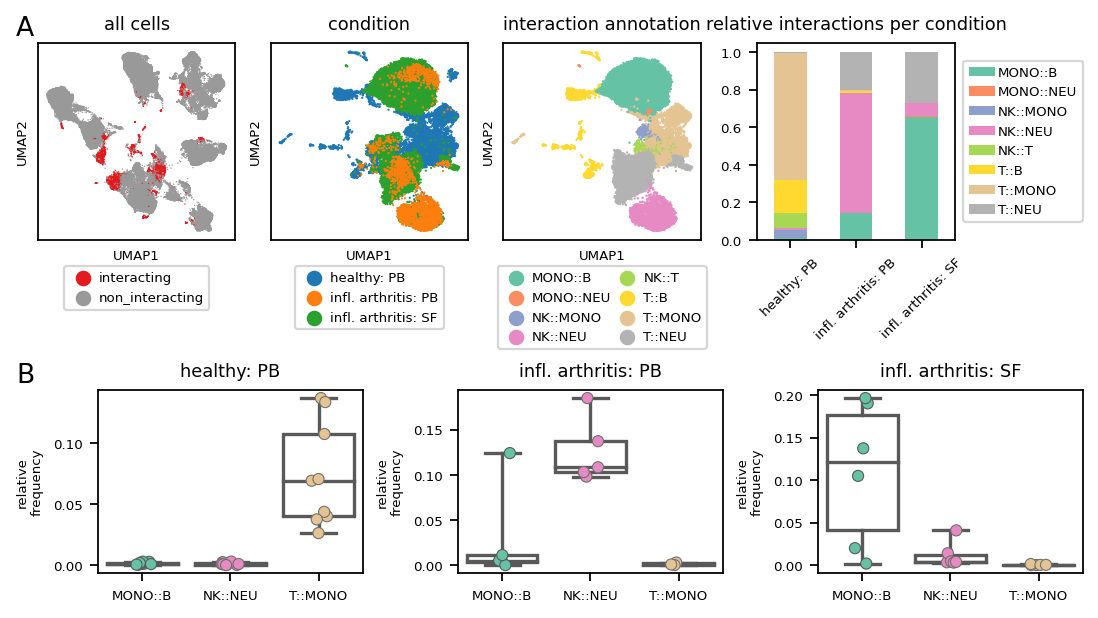

In [51]:
import figure_config as cfg
sc.set_figure_params(vector_friendly=True, dpi_save=300)

fig = plt.figure(layout = "constrained",
                 figsize = (cfg.FIGURE_WIDTH_FULL, cfg.FIGURE_HEIGHT_FULL/2.5))
gs = GridSpec(ncols = 1,
              nrows = 2,
              figure = fig,
              height_ratios = [1,0.7])
a_coords = gs[0]
b_coords = gs[1]

fig_a = fig.add_subplot(a_coords)
fig_b = fig.add_subplot(b_coords)

sns.reset_defaults()
color_code = generate_subfigure_a(fig, fig_a, a_coords, "A")
generate_subfigure_b(fig, fig_b, b_coords, "B", color_code)


plt.savefig(os.path.join(cfg.figure_output, "Figure6.pdf"), dpi = 300, bbox_inches = "tight")
plt.show()